# <b><u> Project Title : Traffic Jam: Predicting People's Movement into Nairobi </u></b>

## <b> Problem Description </b>

### This challenge asks you to build a model that predicts the number of seats that Mobiticket can expect to sell for each ride, i.e. for a specific route on a specific date and time. There are 14 routes in this dataset. All of the routes end in Nairobi and originate in towns to the North-West of Nairobi towards Lake Victoria.


### The towns from which these routes originate are:

* Awendo
* Homa Bay
* Kehancha
* Kendu Bay
* Keroka
* Keumbu
* Kijauri
* Kisii
* Mbita
* Migori
* Ndhiwa
* Nyachenge
* Oyugis
* Rodi
* Rongo
* Sirare
* Sori

### The routes from these 14 origins to the first stop in the outskirts of Nairobi takes approximately 8 to 9 hours from time of departure. From the first stop in the outskirts of Nairobi into the main bus terminal, where most passengers get off, in Central Business District, takes another 2 to 3 hours depending on traffic.

### The three stops that all these routes make in Nairobi (in order) are:

1. Kawangware: the first stop in the outskirts of Nairobi
2. Westlands
3. Afya Centre: the main bus terminal where most passengers disembark

### All of these points are mapped [here](https://www.google.com/maps/d/viewer?mid=1Ef2pFdP8keVHHid8bwju2raoRvjOGagN&ll=-0.8281897101491997%2C35.51706279999996&z=8).

### Passengers of these bus (or shuttle) rides are affected by Nairobi traffic not only during their ride into the city, but from there they must continue their journey to their final destination in Nairobi wherever that may be. Traffic can act as a deterrent for those who have the option to avoid buses that arrive in Nairobi during peak traffic hours. On the other hand, traffic may be an indication for people’s movement patterns, reflecting business hours, cultural events, political events, and holidays.

In [2]:
##importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Capstons Projects/Supervised ML (Regression) - Capstone Project/train_revised.csv')

In [6]:
dataset.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49


In [7]:
#Shape
dataset.shape

(51645, 10)

Since the target Variable is not provided, So we should have to generate it.

In [8]:
num_of_seats = dataset.groupby(['ride_id'])['seat_number'].count()

In [9]:
num_of_seats = num_of_seats.reset_index().rename(columns= {'seat_number': 'number_of_tickets'})

In [10]:
dataset = dataset.merge(num_of_seats, how='left', on='ride_id')

In [11]:
dataset.shape

(51645, 11)

Now our Data has 11 columns

In [12]:
#getting some information about the variables
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51645 entries, 0 to 51644
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ride_id            51645 non-null  int64 
 1   seat_number        51645 non-null  object
 2   payment_method     51645 non-null  object
 3   payment_receipt    51645 non-null  object
 4   travel_date        51645 non-null  object
 5   travel_time        51645 non-null  object
 6   travel_from        51645 non-null  object
 7   travel_to          51645 non-null  object
 8   car_type           51645 non-null  object
 9   max_capacity       51645 non-null  int64 
 10  number_of_tickets  51645 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 4.7+ MB


In [13]:
dataset.isna().sum()

ride_id              0
seat_number          0
payment_method       0
payment_receipt      0
travel_date          0
travel_time          0
travel_from          0
travel_to            0
car_type             0
max_capacity         0
number_of_tickets    0
dtype: int64

I remove 'payment_receipt' to find to find duplicated values

In [14]:
dataset = dataset.drop('payment_receipt', axis=1)

In [15]:
dataset.duplicated().sum()

169

In [16]:
dataset = dataset.drop_duplicates()

Since there are No null and duplicate Observations

####**Feature Engineering**

---

I generate two new varibles travel_day, travel_month to identify the traveling time on the monthaly & daily basses.
And i also convert traveling time in hours to minutes.


*   After creating travel_month and travel_day i drop travel_date.




In [17]:
dataset['travel_date'] = pd.to_datetime(dataset['travel_date'])
dataset['month'] = dataset['travel_date'].dt.month
dataset['day_of_year'] = dataset['travel_date'].dt.dayofyear
dataset['day_of_month'] = dataset['travel_date'].dt.day
dataset['day_of_week'] = dataset['travel_date'].dt.dayofweek


dataset['travel_time'] = pd.to_datetime(dataset['travel_time'])
dataset['hour'] = dataset['travel_time'].dt.hour
dataset['minutes'] = dataset['travel_time'].dt.minute
dataset['period'] = dataset['travel_time'].dt.hour + dataset['travel_time'].dt.minute/ 60

dataset['period'] = dataset['period'].apply(lambda x: 'em' if x< 7 else('am' if x< 11 else('md' if x<2 else ('ev' if x<6 else 'pm'))))

Now let us find the distance of each origin point from the distination point. I used Nirobi Map to estimate the distance from origin point to destination map.

In [18]:
#Travel Distance
distance = {'Migori': 370 , 'Keroka': 280, 'Homa Bay':360, 'Kisii':305.1, 'Keumbu':295, 'Rongo':332,
'Kijauri':271, 'Oyugis':330.6, 'Awendo':351, 'Sirare':392, 'Nyachenge':326, 'Kehancha': 387.7,
'Kendu Bay':347, 'Sori':399, 'Rodi':348, 'Mbita':401, 'Ndhiwa': 371}
dataset["travel_from_distance"] = dataset.travel_from.map(distance)

#Travel Timing
time = {'Migori': 7*60+8 , 'Keroka': 5*60, 'Homa Bay':7*60, 'Kisii':5*60+34, 'Keumbu':5*60+20, 'Rongo':6*60+21,
'Kijauri':60*4+50,'Oyugis':5*60+50, 'Awendo':6*60+38, 'Sirare':7*60+30, 'Nyachenge':6*60+10, 'Kehancha':7*60+10,
'Kendu Bay':6*60+10, 'Sori':7*60+30, 'Rodi':6*60+40, 'Mbita':7*60+23, 'Ndhiwa': 7*60}

dataset["travel_from_time"]=dataset.travel_from.map(time)

#Travel Speed
dataset["Speed"] = dataset.travel_from_time/dataset.travel_from_distance

In [19]:
dataset.head()

,ride_id,seat_number,payment_method,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,number_of_tickets,month,day_of_year,day_of_month,day_of_week,hour,minutes,period,travel_from_distance,travel_from_time,Speed
0,1442,15A,Mpesa,2017-10-17,2022-11-20 07:15:00,Migori,Nairobi,Bus,49,1,10,290,17,1,7,15,am,370.0,428,1.156757
1,5437,14A,Mpesa,2017-11-19,2022-11-20 07:12:00,Migori,Nairobi,Bus,49,1,11,323,19,6,7,12,am,370.0,428,1.156757
2,5710,8B,Mpesa,2017-11-26,2022-11-20 07:05:00,Keroka,Nairobi,Bus,49,1,11,330,26,6,7,5,am,280.0,300,1.071429
3,5777,19A,Mpesa,2017-11-27,2022-11-20 07:10:00,Homa Bay,Nairobi,Bus,49,5,11,331,27,0,7,10,am,360.0,420,1.166667
4,5778,11A,Mpesa,2017-11-27,2022-11-20 07:12:00,Migori,Nairobi,Bus,49,31,11,331,27,0,7,12,am,370.0,428,1.156757


I droping Some unwanted features

In [20]:
dataset = dataset.drop(['ride_id', 'seat_number', 'travel_date', 'travel_time', 'travel_to'], axis=1)

#### description of the Data

In [21]:
dataset.describe(include='all')

,payment_method,travel_from,car_type,max_capacity,number_of_tickets,month,day_of_year,day_of_month,day_of_week,hour,minutes,period,travel_from_distance,travel_from_time,Speed
count,51476,51476,51476,51476.000000,51476.000000,51476.000000,51476.000000,51476.000000,51476.000000,51476.000000,51476.000000,51476,51476.000000,51476.000000,51476.000000
unique,2,17,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN
top,Mpesa,Kisii,Bus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,am,NaN,NaN,NaN
freq,51364,22587,31835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42056,NaN,NaN,NaN
mean,NaN,NaN,NaN,34.500855,17.274011,5.891930,161.716256,13.528771,2.915320,8.614228,15.803967,NaN,335.286073,377.257304,1.122561
std,NaN,NaN,NaN,18.459386,12.380067,4.112606,123.292433,9.142454,1.951813,3.685139,15.788677,NaN,34.814450,47.823835,0.031087
min,NaN,NaN,NaN,11.000000,1.000000,1.000000,1.000000,1.000000,0.000000,5.000000,0.000000,NaN,271.000000,290.000000,1.058681
25%,NaN,NaN,NaN,11.000000,9.000000,2.000000,52.000000,3.000000,1.000000,7.000000,6.000000,NaN,305.100000,334.000000,1.094723
50%,NaN,NaN,NaN,49.000000,11.000000,4.000000,108.000000,14.000000,3.000000,7.000000,10.000000,NaN,332.000000,381.000000,1.109105
75%,NaN,NaN,NaN,49.000000,26.000000,10.000000,285.000000,20.000000,5.000000,9.000000,20.000000,NaN,370.000000,428.000000,1.156757


####Examin the Data Distribution of target Variable

In [22]:
target_var = dataset['number_of_tickets']

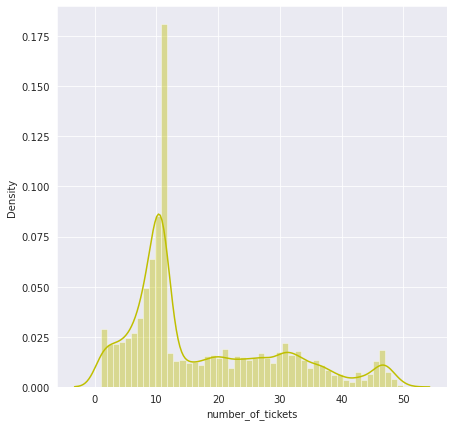

In [23]:
plt.figure(figsize=(7,7))
sns.distplot(target_var, color='y')
plt.show()

# Exploratory Data Analysis (EDA)

###First I perform EDA for **Numerical Variables**

In [31]:
numerical_feature = [col for col in dataset.describe().columns if col not in ['number_of_tickets'] ]
numerical_feature

['max_capacity',
 'month',
 'day_of_year',
 'day_of_month',
 'day_of_week',
 'hour',
 'minutes',
 'travel_from_distance',
 'travel_from_time',
 'Speed']

####Univariant Analysis

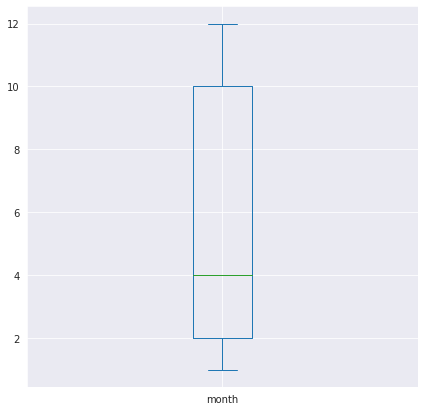

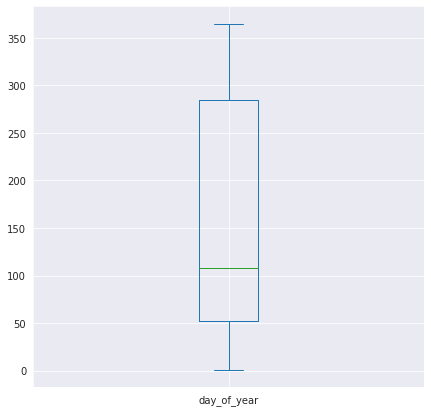

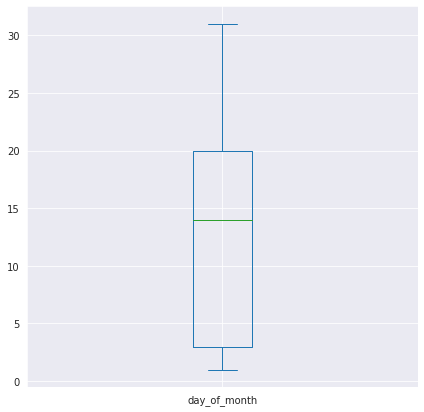

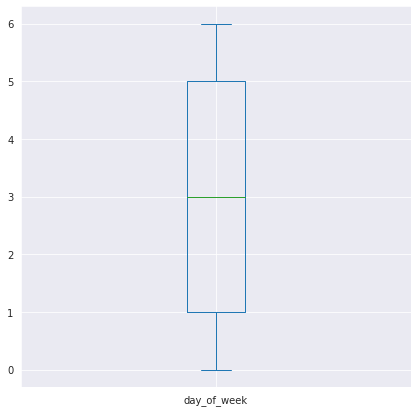

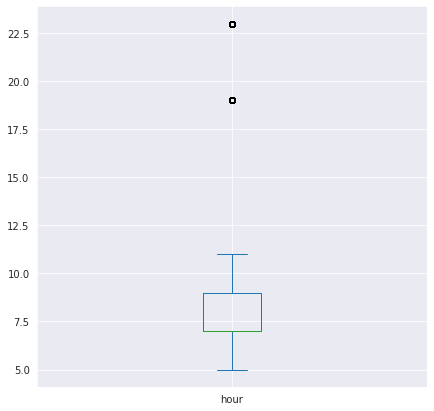

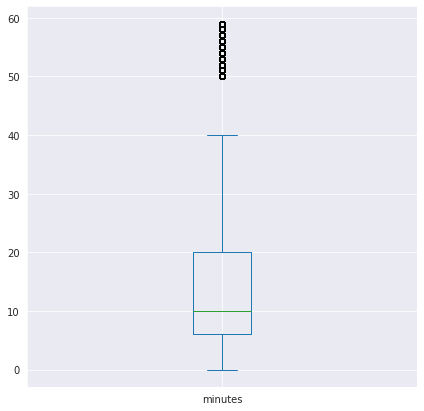

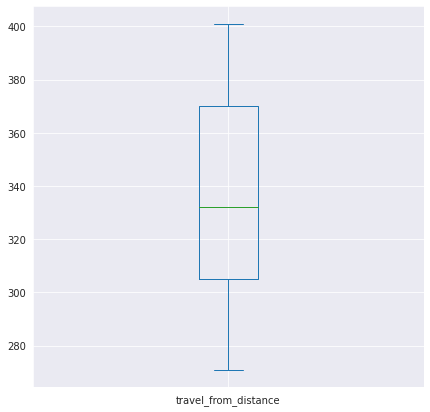

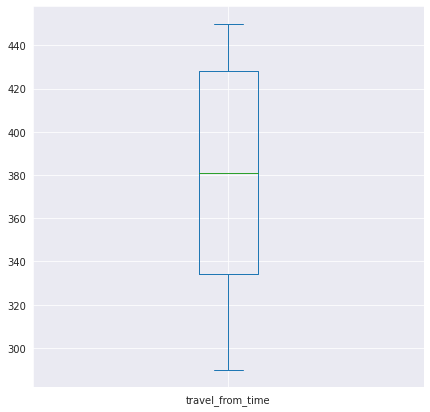

In [32]:
for col in numerical_feature[1:-1]:
  plt.figure(figsize=(7,7))
  dataset[col].plot(kind='box')
  

I draw a box plot of numerical variables to visualize the Outliers. Since there are no outliers.

### Bivarient Analysis

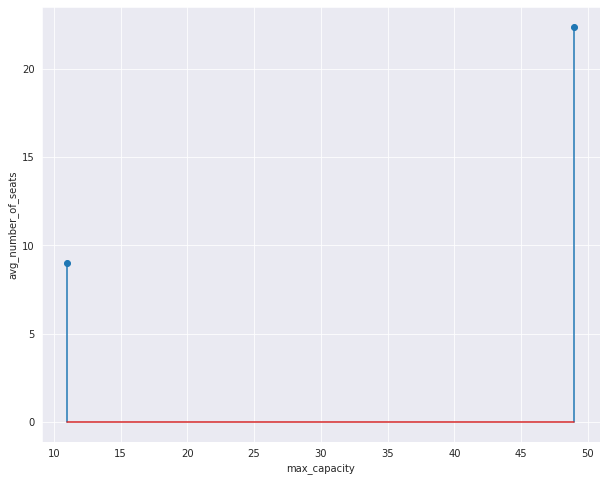

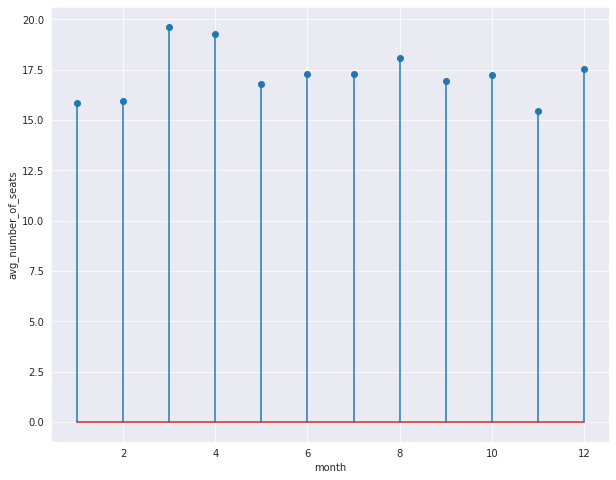

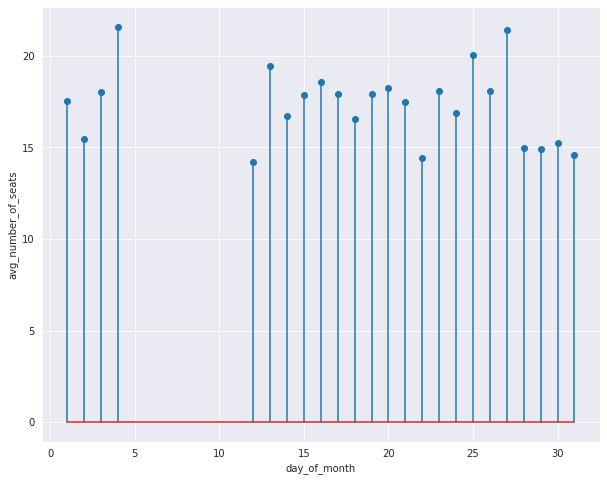

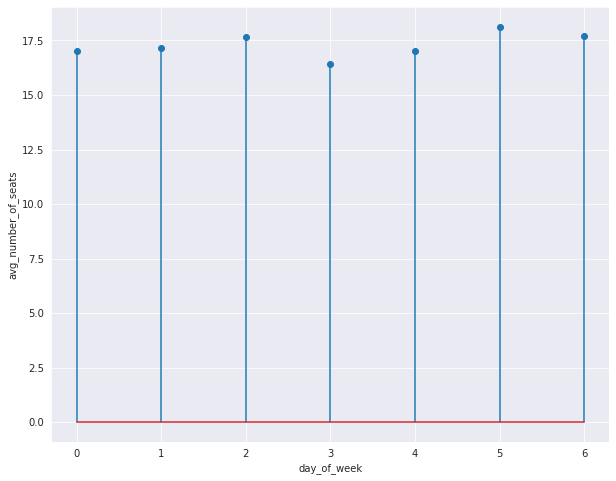

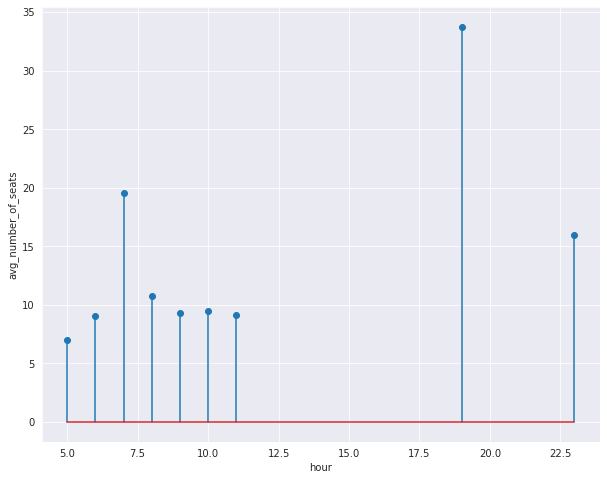

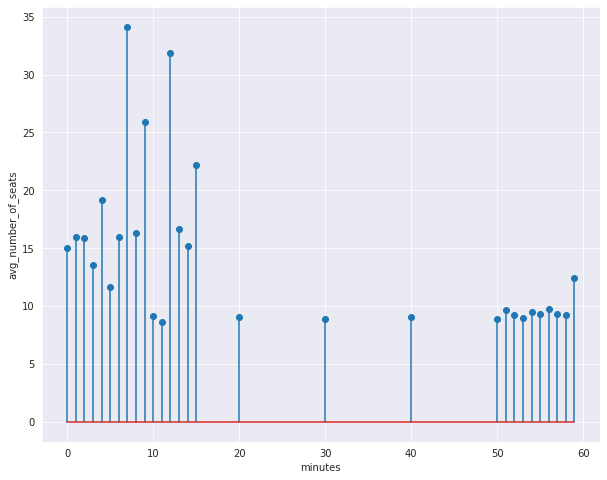

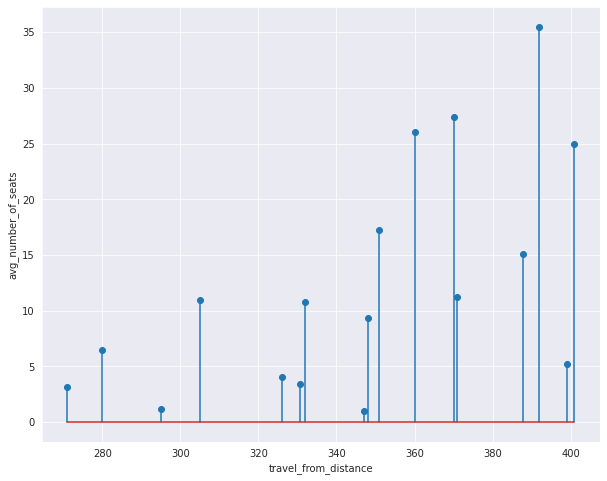

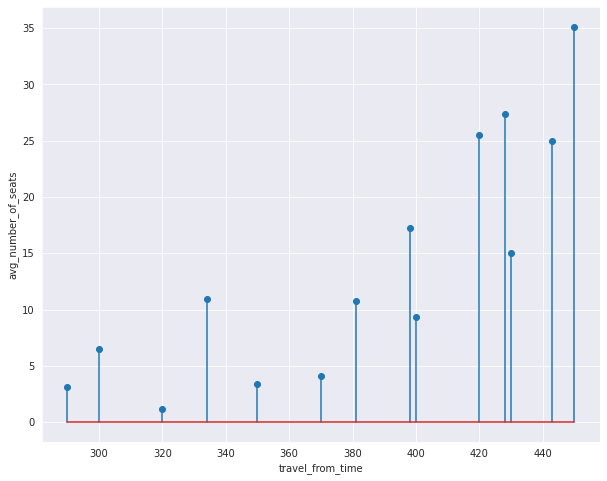

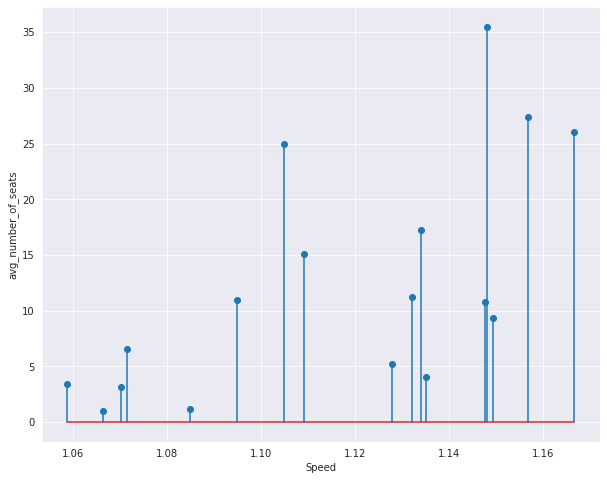

In [33]:
for col in numerical_feature:
  if col != 'day_of_year':
    dd = dataset.groupby([col])['number_of_tickets'].mean()
    dd = dd.reset_index()
    plt.figure(figsize =(10, 8))
    plt.stem(dd[col], dd['number_of_tickets'])
    plt.xlabel(col)
    plt.ylabel('avg_number_of_seats')

plt.show()

###EDA For **Categorical Variabels**

In [34]:
categorical_features = dataset.describe(include = ['object', 'category']).columns
categorical_features

Index(['payment_method', 'travel_from', 'car_type', 'period'], dtype='object')

####Univarient Analysis

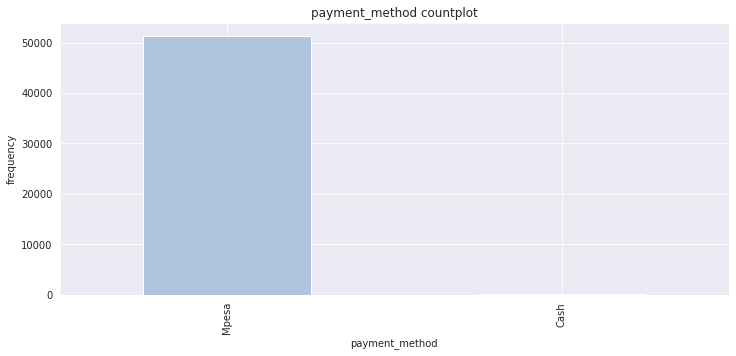

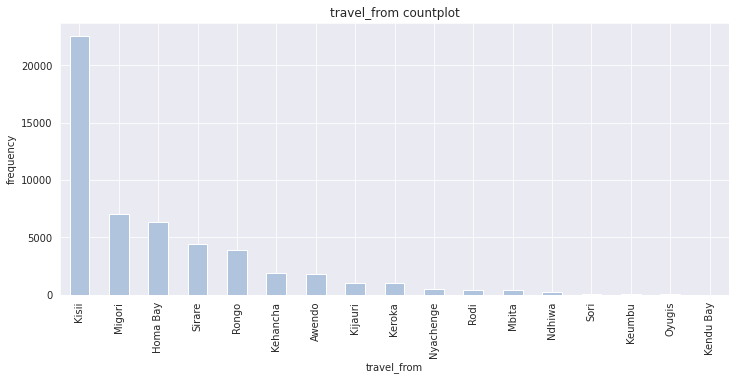

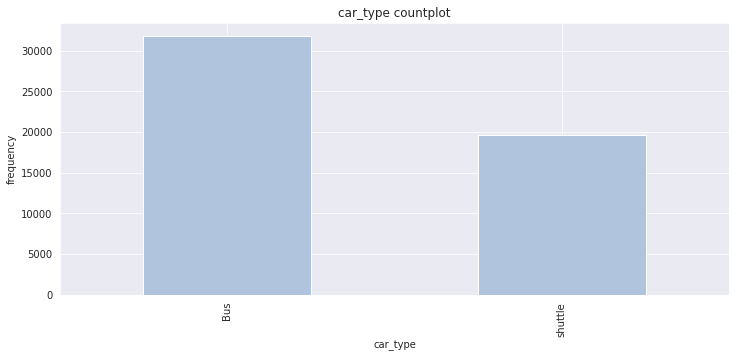

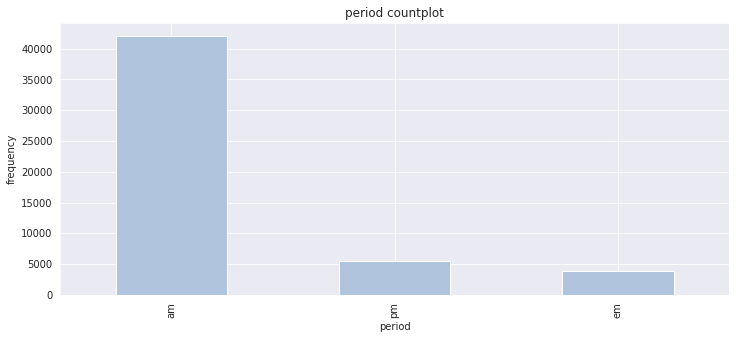

In [35]:
for col in categorical_features:
  count = dataset[col].value_counts()
  plt.figure(figsize = (12,5))
  count.plot(kind='bar', color='lightsteelblue')
  plt.xlabel(col)
  plt.ylabel('frequency')
  plt.title(f'{col} countplot')

plt.show()

from the above plots i comes to some conclusions:-


*   The route originat from kisii town has more movement as compare to other towns.

*   Movement of peoples are linear from May to september. and increase in the months from December to April
* The vehicle having 49 seats capacity are more in use as compare to vehicle having 11 seat capacity

* there is no ride is happining and the movment of peoples are more at morning as compaire Evening.


### Bivarient Analysis

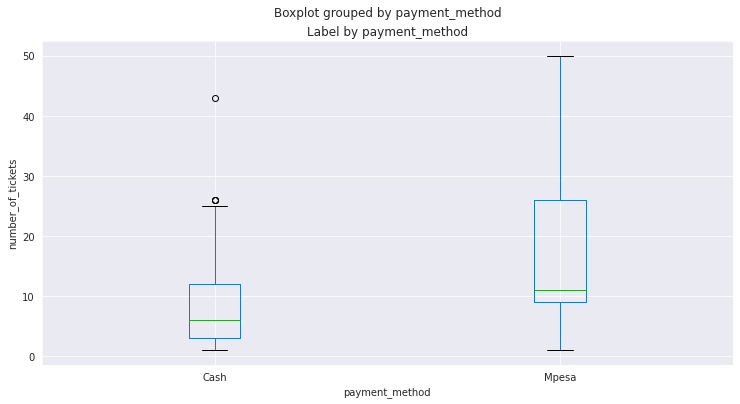

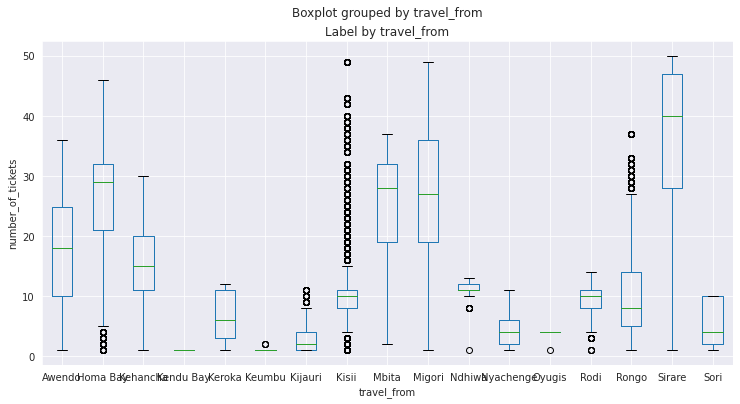

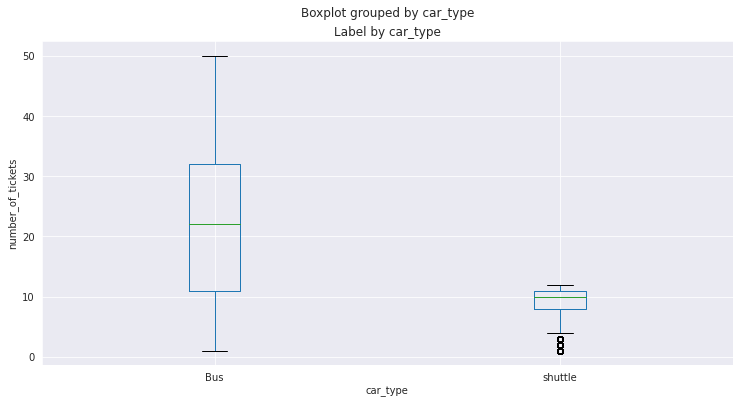

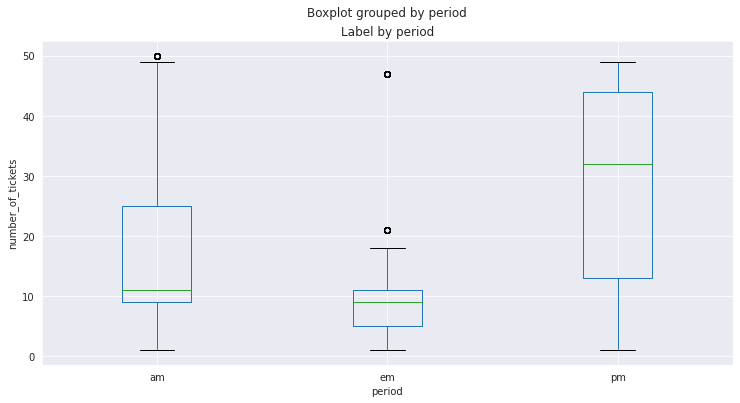

In [36]:
for col in categorical_features:
  fig = plt.figure(figsize = (12,6))
  ax = fig.gca()
  dataset.boxplot(column = 'number_of_tickets', by=col, ax = ax)
  ax.set_title('Label by ' + col)
  ax.set_ylabel('number_of_tickets')

plt.show()

what i get from above plots :-


*   More tickets are booked through Mpesa Payment Method.
*   tickets of buses are more booked as compaire shuttle.
* In March & April months more tickets are booked as compaire to other months.
* Booking of tickets are linear in all days of the weeks.
* As natural more capacity have more seats for booking, therefore 49 seats capacity vehicle have more booking as compare less capacity vehicle.
* Above we see that on bar plot the Morning Strength is more as compair to Evening but on box plot the number of tickets are more in Evening.
I thing it is becouse at morning time some peoples use train to reach their places on time. 




# Feature Engineering

In [37]:
df = dataset.copy()

In [38]:
conv_dict = {17:2, 19:2, 26:3, 27:3, 20:2, 18:2, 16:2, 15:2, 14:2, 13:2,  4:1, 28:2, 31:3, 30:3, 29:3, 25:3, 24:3,
       23:3, 22:3, 21:3, 12:1,  3:1,  2:1,  1:2}
df['day_of_month'].replace(conv_dict,inplace=True)

In [39]:
dict_cov = {12:1,2:1,1:1,2:1,4:2,11:2,9:3,7:3,8:3,10:3,6:3,5:3}
df['month'].replace(dict_cov,inplace=True)

In [40]:
#label encoding
encoding = {
    'payment_method' : {'Cash' : 0, 'Mpesa' : 1}, 
    'car_type': {'Bus': 0, 'shuttle' : 1}
}

df = df.replace(encoding)

In [41]:
df = pd.get_dummies(df, columns= ['travel_from', 'month', 'day_of_month'])

In [44]:
df = df.drop(['max_capacity', 'number_of_tickets', 'period'], axis=1)

In [45]:
df.head()

,payment_method,car_type,day_of_year,day_of_week,hour,minutes,travel_from_distance,travel_from_time,Speed,travel_from_Awendo,travel_from_Homa Bay,travel_from_Kehancha,travel_from_Kendu Bay,travel_from_Keroka,travel_from_Keumbu,travel_from_Kijauri,travel_from_Kisii,travel_from_Mbita,travel_from_Migori,travel_from_Ndhiwa,travel_from_Nyachenge,travel_from_Oyugis,travel_from_Rodi,travel_from_Rongo,travel_from_Sirare,travel_from_Sori,month_1,month_2,month_3,day_of_month_1,day_of_month_2,day_of_month_3
0,1,0,290,1,7,15,370.0,428,1.156757,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1,1,0,323,6,7,12,370.0,428,1.156757,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
2,1,0,330,6,7,5,280.0,300,1.071429,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,0,331,0,7,10,360.0,420,1.166667,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,1,0,331,0,7,12,370.0,428,1.156757,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


**final features**

In [46]:
features_ = df.describe().columns
features_

Index(['payment_method', 'car_type', 'day_of_year', 'day_of_week', 'hour',
       'minutes', 'travel_from_distance', 'travel_from_time', 'Speed',
       'travel_from_Awendo', 'travel_from_Homa Bay', 'travel_from_Kehancha',
       'travel_from_Kendu Bay', 'travel_from_Keroka', 'travel_from_Keumbu',
       'travel_from_Kijauri', 'travel_from_Kisii', 'travel_from_Mbita',
       'travel_from_Migori', 'travel_from_Ndhiwa', 'travel_from_Nyachenge',
       'travel_from_Oyugis', 'travel_from_Rodi', 'travel_from_Rongo',
       'travel_from_Sirare', 'travel_from_Sori', 'month_1', 'month_2',
       'month_3', 'day_of_month_1', 'day_of_month_2', 'day_of_month_3'],
      dtype='object')

In [47]:
features_.size

32

In [48]:
df_pr = df[features_]

In [49]:
X = df_pr
Y = dataset['number_of_tickets']

# Model Building

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import time

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[features_] = scaler.fit_transform(X)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size= 0.3, random_state= 2, stratify=Y)

In [53]:
print(X_train.shape)
print(X_test.shape)

(36033, 32)
(15443, 32)


##Linear Regression


---



In [54]:
begin = time.time()
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
end = time.time()
#Training Time
lg_algo_training_time = end - begin

In [55]:
#Training score
linear_reg_score = linear_reg.score(X_train, y_train)

In [56]:
lg_train_pred = linear_reg.predict(X_train)
lg_test_pred = linear_reg.predict(X_test)

In [57]:
def evaluate(given, predicted):
  MSE = mean_squared_error(given, predicted)
  RMSE = np.sqrt(mean_squared_error(given, predicted))

  RMSPE = (RMSE / np.mean(y_train))*100
  print('Mean Squre Error : ', MSE )

  print('Root Mean Squre Error : ', RMSE)
  print('Root Mean Squre Percentage Error : ', RMSPE)
  print('R2 Score : ', r2_score( given, predicted))

####Model Evalution

In [59]:
print('Train Dataset')
print('-------------')
evaluate(y_train, lg_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, lg_test_pred)

Train Dataset
-------------
Mean Squre Error :  63.800308200567486
Root Mean Squre Error :  7.987509511766949
Root Mean Squre Percentage Error :  46.239477772627566
R2 Score :  0.583693231956344
 
Test Dataset
-------------
Mean Squre Error :  64.29627562403505
Root Mean Squre Error :  8.01849584548343
Root Mean Squre Percentage Error :  46.41885682526314
R2 Score :  0.5805478562454287


##Lasso Regression


---

In [60]:
from sklearn.linear_model import Lasso
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
begin = time.time()
lasso_reg = GridSearchCV(lasso, param_grid= parameters, scoring= 'neg_mean_squared_error', cv=5)
lasso_reg.fit(X_train, y_train)
end = time.time()
#Training Time
lasso_algo_training_time = end - begin

In [61]:
print("The best fit alpha value is found out to be :" ,lasso_reg.best_params_)
print("\nUsing ",lasso_reg.best_params_, " the negative mean squared error is: ", lasso_reg.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.01}

Using  {'alpha': 0.01}  the negative mean squared error is:  -63.89888358708689


In [62]:
lasso_reg = lasso_reg.best_estimator_
#Training Score
lasso_score = lasso_reg.score(X_train, y_train)

In [63]:
lasso_train_pred = lasso_reg.predict(X_train)
lasso_test_pred = lasso_reg.predict(X_test)

####Model Evaluation

In [64]:
print('Train Dataset')
print('-------------')
evaluate(y_train, lasso_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, lasso_test_pred)

Train Dataset
-------------
Mean Squre Error :  63.792656093926084
Root Mean Squre Error :  7.98703049286317
Root Mean Squre Percentage Error :  46.23670474507481
R2 Score :  0.5837431631224224
 
Test Dataset
-------------
Mean Squre Error :  64.30174810397365
Root Mean Squre Error :  8.018837079276125
Root Mean Squre Percentage Error :  46.42083221851298
R2 Score :  0.5805121552126765


## Ridge Regression


---


In [65]:
from sklearn.linear_model import Ridge

In [66]:
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
begin = time.time()
ridge_reg = GridSearchCV(ridge, param_grid= parameters, scoring= 'neg_mean_squared_error', cv=5)
ridge_reg.fit(X_train, y_train)
end = time.time()
#Training Time
ridge_algo_training_time = end - begin

In [67]:
print("The best fit alpha value is found out to be :" ,ridge_reg.best_params_)
print("\nUsing ",ridge_reg.best_params_, " the negative mean squared error is: ", ridge_reg.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-10}

Using  {'alpha': 1e-10}  the negative mean squared error is:  -63.89657258430267


In [68]:
ridge_reg = ridge_reg.best_estimator_
#ridge score
ridge_score = ridge_reg.score(X_train, y_train)

In [69]:
ridge_train_pred = ridge_reg.predict(X_train)
ridge_test_pred = ridge_reg.predict(X_test)

Model Evaluation

In [70]:
print('Train Dataset')
print('-------------')
evaluate(y_train, ridge_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, ridge_test_pred)

Train Dataset
-------------
Mean Squre Error :  63.79011320521438
Root Mean Squre Error :  7.986871302657529
Root Mean Squre Percentage Error :  46.23578319725512
R2 Score :  0.5837597558601523
 
Test Dataset
-------------
Mean Squre Error :  64.29491145914135
Root Mean Squre Error :  8.018410781391868
Root Mean Squre Percentage Error :  46.418364391524534
R2 Score :  0.5805567557016343


## Decision Tree

In [71]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
import graphviz

In [72]:
Dec_tree_reg = DecisionTreeRegressor(random_state=0)
params = {
    'criterion': ["squared_error", "absolute_error"],
    'splitter' : ["best", "random"],
    'max_depth' : [2, 6, 8],
    'min_samples_split' : [2, 3, 4]
}

begin = time.time()
Dec_tree_reg = GridSearchCV(Dec_tree_reg, param_grid= params,
                            n_jobs=-1, verbose=1,
                            scoring='r2', cv = 2)

Dec_tree_reg.fit(X_train, y_train)
end = time.time()
#Training Time
Dec_algo_training_time = end - begin

Fitting 2 folds for each of 36 candidates, totalling 72 fits


In [73]:
print("The best fit Parameters value are found out to be :" ,Dec_tree_reg.best_params_)
print("\nUsing ",Dec_tree_reg.best_params_, " the r2 Score is: ", Dec_tree_reg.best_score_)

The best fit Parameters value are found out to be : {'criterion': 'squared_error', 'max_depth': 8, 'min_samples_split': 3, 'splitter': 'best'}

Using  {'criterion': 'squared_error', 'max_depth': 8, 'min_samples_split': 3, 'splitter': 'best'}  the r2 Score is:  0.7355177692489203


In [74]:
DecTree_reg = Dec_tree_reg.best_estimator_
#Training Score
DecTree_Score = DecTree_reg.score(X_train, y_train)

In [75]:
DecTree_reg_train_pred = DecTree_reg.predict(X_train)
DecTree_reg_test_pred = DecTree_reg.predict(X_test)

In [76]:
print('Train Dataset')
print('-------------')
evaluate(y_train, DecTree_reg_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, DecTree_reg_test_pred)

Train Dataset
-------------
Mean Squre Error :  40.89764009679339
Root Mean Squre Error :  6.395126276845
Root Mean Squre Percentage Error :  37.021214046217295
R2 Score :  0.7331366438578231
 
Test Dataset
-------------
Mean Squre Error :  42.85869164772827
Root Mean Squre Error :  6.546654996845967
Root Mean Squre Percentage Error :  37.898409731565465
R2 Score :  0.7204010665364948


## Random Forest 

In [79]:
from sklearn.ensemble import RandomForestRegressor

In [80]:
rd_forest_reg = RandomForestRegressor(random_state=42)
param_grid = {
           'max_features' : ['auto', 'sqrt'],
            'max_depth': [10, 30, 50],
            'min_samples_leaf': [1,2,4],
            'min_samples_split': [2, 5, 10],
            'bootstrap' : [True, False] 
}

begin = time.time()
rd_forest_reg = GridSearchCV(rd_forest_reg, param_grid= param_grid, scoring='r2', cv = 2)
rd_forest_reg.fit(X_train, y_train)
end = time.time()

#Training Time
rd_algo_training_time = end - begin

In [81]:
print(f'The best Perameters Value are : {rd_forest_reg.best_params_}')
print(f'By Using : {rd_forest_reg.best_params_} the r2 Score is : {rd_forest_reg.best_score_}')

The best Perameters Value are : {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
By Using : {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2} the r2 Score is : 0.9834599442166729


In [82]:
RD_forest = rd_forest_reg.best_estimator_
#Training Score
RD_forest_score = RD_forest.score(X_train, y_train)

In [83]:
RD_forest_train_pred = RD_forest.predict(X_train)
RD_forest_test_pred = RD_forest.predict(X_test)

In [85]:
print('Train Dataset')
print('-------------')
evaluate(y_train, RD_forest_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, RD_forest_test_pred)

Train Dataset
-------------
Mean Squre Error :  2.553194078569212e-05
Root Mean Squre Error :  0.0050529140884931064
Root Mean Squre Percentage Error :  0.029251183781086768
R2 Score :  0.9999998334001817
 
Test Dataset
-------------
Mean Squre Error :  0.8256520881322833
Root Mean Squre Error :  0.9086539980280081
Root Mean Squre Percentage Error :  5.260173560097682
R2 Score :  0.9946136609780075


# Gradient Boosting Regressor

In [86]:
from sklearn.ensemble import GradientBoostingRegressor

GBM_reg = GradientBoostingRegressor(min_samples_leaf=50, max_depth=8, random_state= 42)
param_grid = {
    'learning_rate':[0.01, 0.1, 0.2],
    'max_depth' : [4, 8, 12],
    'min_samples_split' : [4, 6, 8],
    'min_samples_leaf' : [2, 5, 7],
    'max_features' :  ['auto', 'sqrt']
}

begin = time.time()
GBM_reg = GridSearchCV(GBM_reg, param_grid= param_grid, scoring= 'neg_mean_squared_error', cv = 2)

GBM_reg.fit(X_train, y_train)

end = time.time()

#training Time
GBM_Training_time = end - begin

In [87]:
print(f'The best Perameters Value are : {GBM_reg.best_params_}')
print(f'Bu Using : {GBM_reg.best_params_} the neg_mean_squared_error is : {GBM_reg.best_score_}')

The best Perameters Value are : {'learning_rate': 0.2, 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4}
Bu Using : {'learning_rate': 0.2, 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4} the neg_mean_squared_error is : -2.7267507730274065


In [88]:
GBM_reg = GBM_reg.best_estimator_

#Training Score
GBM_score = GBM_reg.score(X_train, y_train)

In [89]:
GBM_reg_train_pred = GBM_reg.predict(X_train)
GBM_reg_test_pred = GBM_reg.predict(X_test)

In [90]:
print('Train Dataset')
print('-------------')
evaluate(y_train, GBM_reg_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, GBM_reg_test_pred)

Train Dataset
-------------
Mean Squre Error :  0.195987622095233
Root Mean Squre Error :  0.4427048927843841
Root Mean Squre Percentage Error :  2.56280671961399
R2 Score :  0.9987211507932763
 
Test Dataset
-------------
Mean Squre Error :  1.1680295333153778
Root Mean Squre Error :  1.0807541502651645
Root Mean Squre Percentage Error :  6.256456713477669
R2 Score :  0.9923800797641436


#XGBoost

In [91]:
from xgboost import XGBRegressor

XGB_reg = XGBRegressor(random_state= 42, verbosity= 0)
param_grid = {
    'gamma' : [2, 5, 8],
    'reg_alpha' : [10, 20, 35],
    'colsample_bytree' : [0.5, 1], 
    'max_depth': [7,12,18],
    'n_estimators' : [180]
    }

begin = time.time()
XGB_reg = GridSearchCV(XGB_reg, param_grid= param_grid, scoring= 'neg_mean_squared_error', cv = 2)

XGB_reg.fit(X_train, y_train)
end = time.time()

#Training Time
XGB_algo_training_time = end - begin

In [92]:
XGB_reg.best_estimator_.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 2,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 18,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 180,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 42,
 'reg_alpha': 10,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 0}

In [93]:
XGB_reg = XGB_reg.best_estimator_

#XGB Score
XGB_score = XGB_reg.score(X_train, y_train)

In [94]:
XGB_reg_train_pred = XGB_reg.predict(X_train)
XGB_reg_test_pred = XGB_reg.predict(X_test)

In [95]:
print('Train Dataset')
print('-------------')
evaluate(y_train, XGB_reg_train_pred)
print(' ')
print('Test Dataset')
print('-------------')
evaluate(y_test, XGB_reg_test_pred)

Train Dataset
-------------
Mean Squre Error :  0.5098815925489988
Root Mean Squre Error :  0.7140599362441494
Root Mean Squre Percentage Error :  4.1336737692323835
R2 Score :  0.9966729446319957
 
Test Dataset
-------------
Mean Squre Error :  1.458091929823218
Root Mean Squre Error :  1.207514774163537
Root Mean Squre Percentage Error :  6.990270556523296
R2 Score :  0.9904877882922513


#Model Validation

In [98]:
Performance_ = pd.DataFrame(columns=['Algorithum', 'Dataset', 'MSE', 'RMSE', 'R2_Score', 'Adjecent_R2'])
algos = [linear_reg, lasso_reg, ridge_reg, Dec_tree_reg, rd_forest_reg, GBM_reg, XGB_reg]
algo_name = ['LinearRegression', 'LassoRegression', 'RidgeRegression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoosting']
Datasets_ = ['Train_set', 'Test_set']

for i in Datasets_:
  for j, v in enumerate(algo_name):
    if i == 'Train_set':
      y_pred = algos[j].predict(X_train)
      MSE = round(mean_squared_error(y_train, y_pred), 2)
      RMSE = round(np.sqrt(MSE), 2)
      R2 = round(r2_score(y_train, y_pred), 2)
      adj_r2 = round(1-(1-r2_score(y_train, y_pred))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)), 2)
      Performance_ = Performance_.append({'Algorithum': v , 'Dataset': i, 'MSE': MSE, 
                                            'RMSE': RMSE,'R2_Score': R2,'Adjecent_R2': adj_r2}, ignore_index= True)
    else:
      y_pred = algos[j].predict(X_test)
      MSE = round(mean_squared_error(y_test, y_pred), 2)
      RMSE = round(np.sqrt(MSE),2)
      R2 = round(r2_score(y_test, y_pred), 2)
      adj_r2 = round(1-(1-r2_score(y_test, y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)), 2)
      Performance_ = Performance_.append({'Algorithum': v , 'Dataset': i, 'MSE': MSE, 
                                            'RMSE': RMSE,'R2_Score': R2,'Adjecent_R2': adj_r2}, ignore_index= True)    

In [99]:
#Algorithum vise Performance Trable
perf_pivot = Performance_.pivot(index='Algorithum', columns=['Dataset'])
perf_pivot

MSE               RMSE           R2_Score            \
Dataset           Test_set Train_set Test_set Train_set Test_set Train_set   
Algorithum                                                                   
Decision Tree        42.86     40.90     6.55      6.40     0.72      0.73   
Gradient Boosting     1.17      0.20     1.08      0.45     0.99      1.00   
LassoRegression      64.30     63.79     8.02      7.99     0.58      0.58   
LinearRegression     64.30     63.80     8.02      7.99     0.58      0.58   
Random Forest         0.83      0.00     0.91      0.00     0.99      1.00   
RidgeRegression      64.29     63.79     8.02      7.99     0.58      0.58   
XGBoosting            1.46      0.51     1.21      0.71     0.99      1.00   

                  Adjecent_R2            
Dataset              Test_set Train_set  
Algorithum                               
Decision Tree            0.72      0.73  
Gradient Boosting        0.99      1.00  
LassoRegression          0.58      0.58  
LinearRegression         0.58      0.58  
Random Forest            0.99      1.00  
RidgeRegression          0.58      0.58  
XGBoosting               0.99      1.00